 # We import the data and clean spurious dates

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

#Load the spreadsheet
allbirds = pd.read_csv("AllBirdsv4.csv",header=0)

# There appears to be some erroneous dates in the data so I drop these
allbirds["drop"] = allbirds["Date"].apply(lambda date: date[-2:] == "00" and date[-4:] != "2000" and date[-4:] != "2010")
# There appears to be some unsure locations in the data (indicated by ?) so I drop these
allbirds['X'] = allbirds['X'].map(lambda x: int(str(x).lstrip('?')))
allbirds['Y'] = allbirds['Y'].map(lambda y: int(str(y).rstrip('?')))


allbirds = allbirds[allbirds["drop"] == False]

# Convert the dates to date format and group them in to months
allbirds["Date"] = pd.to_datetime(allbirds["Date"],format='%m/%d/%Y')
allbirds["Date_month_year"] =  pd.to_datetime(allbirds['Date']).dt.to_period('m')

# Select the species we are interested in 

In [2]:
def setSpeciesOfInterest(Species):
    # This function is redundant as we access the value of the dropdown directly via the interact object, but a null function is required for interactive to run
    return

species = interactive(setSpeciesOfInterest,Species=list(allbirds.English_name.unique()))
display(species)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnU3BlY2llcycsIG9wdGlvbnM9KCdSb3NlLWNyZXN0ZWQgQmx1ZSBQaXBpdCcsICdCbHVlLWNvbGxhcmVkIFppcHDigKY=


# Review the distribution of calls for the selected species over time

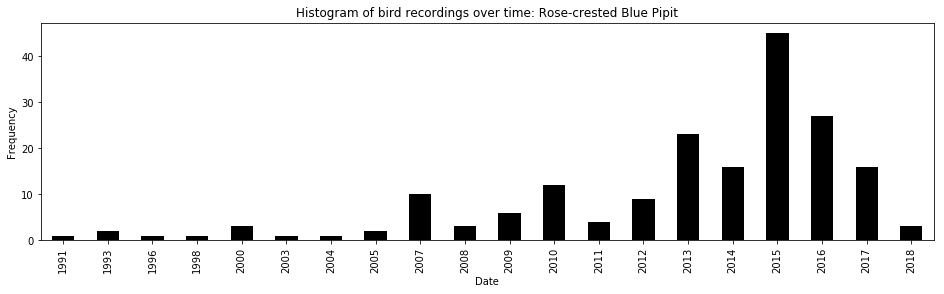

In [3]:
speciesOfInterest = species.kwargs["Species"]
species_df = allbirds[allbirds["English_name"] == speciesOfInterest]
plt.figure(figsize=(16,4))
species_df["English_name"].groupby(species_df["Date"].dt.year).count().plot(kind="bar",color="black")
plt.title("Histogram of bird recordings over time: %s" % speciesOfInterest)
plt.ylabel("Frequency")
plt.show()

### Plot 1
Simple plot showing the centroid of the species for each month/year

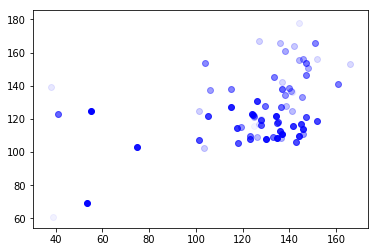

In [4]:
# We identify each unique month/year combo in the dataset and create a new dataframe (centroids) to store the centre points in:
unique_dates = set(species_df["Date_month_year"])
centroids = []

# Iterate through each date, calculate the centre point of the observations and add this to the new dataframe
for d in unique_dates:
    avgValues = species_df[species_df["Date_month_year"]==d][["X","Y"]].astype(float).mean(axis=0)
    centroids.append([str(d),avgValues[0],avgValues[1]]) 
    
# We sort the dataframe we created by date
# We reset the index because this forces a new date-ordered integer index (autoincrementing from 0). We drop the old index which was not date-ordered.
centroids = pd.DataFrame(centroids,columns=["Date","X","Y"]).sort_values(by="Date").reset_index().drop("index",axis=1)

# We iterate through the centroids we calculated adding them to the plot.
# The index determines the opacity (alpha).   
for index,row in centroids.iterrows():
    plt.scatter(row["X"],row["Y"],color="blue",alpha=index/len(centroids))
plt.show()

### Discussion of Plot 1
The plot is successful in using opacity as a visual channel to show how old an observation is. However, it is difficult to glean how the species was moving over time. The opacity measure is also misleading, as we have simply ordered the data from oldest to newest and opacity reflects the observation's position in this order. Given the high variance in the  gap between observations within the data, this is problematic.

## Plot 2

In [5]:

# # #centroids2 = centroids.set_index("Date").rolling(window=40).mean()

# # There appears to be some erroneous dates in the data so I drop these
# allbirds = pd.read_csv("AllBirdsv4.csv",header=0)
# allbirds["drop"] = allbirds["Date"].apply(lambda date: date[-2:] == "00")
# allbirds = allbirds[allbirds["drop"] == False]

# # Convert the dates to date format and group them in to months
# allbirds["Date"] = pd.to_datetime(allbirds["Date"],format='%m/%d/%Y')
# allbirds["Date_month_year"] =  pd.to_datetime(allbirds['Date'])#.dt.to_period('m')


# unique_dates = set(species_df["Date_month_year"])

centroids = []
for d in unique_dates:
    avgValues = species_df[species_df["Date_month_year"]==d][["X","Y"]].astype(float).mean(axis=0)
    centroids.append([str(d),avgValues[0],avgValues[1]]) 

centroids = pd.DataFrame(centroids,columns=["Date","X","Y"]).sort_values(by="Date")
centroids = centroids.set_index(pd.DatetimeIndex(centroids['Date']))

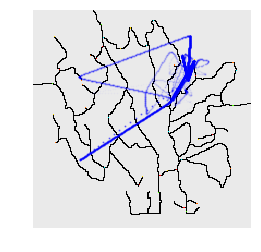

In [6]:
centroids# We create a function to calculate how old an observation so we can adjust the opacity accordingly
def calculateDays(d,latestdate):
    return (latestdate-d)

# Create a clone of the previous dataframe of centroids without the 'date' column which can't be interpolated
centroids2 = centroids.drop("Date",axis=1)

# Identify the latest date in the dataset, as it is our reference point for how 'old' an observation is
latestdate = centroids2.index.max()

# Resample the dataset in to three day blocks, interpolating the gaps. We also take a moving average to smooth the data.
# 3 days was found by trial and error, balancing speed to render the visualisation, with smoothness of the path generated
centroids2 = centroids2.resample("D").interpolate()[::3]
centroids2 = centroids2.rolling(window=20).mean()

# We calculate the number of days old each observation is, and normalise that to create an opacity measure.
centroids2["Days"] = centroids2.index
centroids2["Days"] = centroids2["Days"].apply(lambda d: calculateDays(d,latestdate))
centroids2["Opacity"] = centroids2["Days"].apply(lambda d: d.days)/max(centroids2["Days"].apply(lambda d: d.days))
centroids2["Opacity"] = centroids2["Opacity"].apply(lambda o: o**2)

# Load the bitmap of the park map we were given and display it
img=mpimg.imread('Lekagul Roadways 2018.bmp')
plt.imshow(img)

# Iterate through the centroids and plot each one on top of the map
for index,row in centroids2.iterrows():
    plt.scatter(row["X"],200-row["Y"],color="b",alpha=row["Opacity"],s=1)

# Turn off the axis and display the visualisation
plt.axis('off')
plt.show()

### Discussion of Plot 2
It is much easier in this plot to infer the movement of the species over time. Interpolation and smoothing of the values has created a much more useful visualisation. However, because the species has effectively returned to an area it has begun in, it is very difficult to see the lower opacity 'path' when it occupies the same space as the higher opacity path. This is a key failing of the technique.

## Plot 3
Instead of using opacity as a visual channel, I experiment with using colour instead.

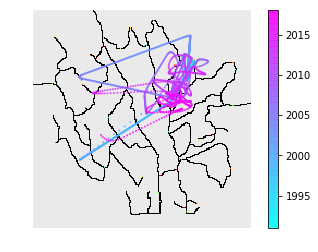

In [7]:
# We create a variation on our existing dataframe, dropping the old days/opacity columns and extracting just the year
centroids3 = centroids2.drop(["Days","Opacity"],axis=1).reset_index()
centroids3["Year"] = centroids3["Date"].apply(lambda d: d.year)
centroids3.set_index("Date",inplace=True)

plt.imshow(img)

# We can provide the plt.scatter method with the two vectors since we are not specifying opacity
plt.scatter(centroids3["X"],200-centroids3["Y"],s=1,c=centroids3["Year"],cmap="cool",alpha=0.7)
plt.colorbar()
# Turn off the axis and display the visualisation
plt.axis('off')
plt.show()

### Discussion of Plot 3
This plot makes it easier to identify where the species was in the same space and its movements within those periods because they are displayed with the same opacity. The addition of the colour bar allows us to identify the period associated with a segment of the path.

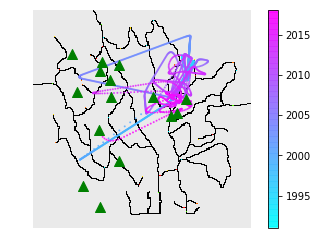

In [8]:
# Load the locations of the recordings from Kasios
testobservations = pd.read_csv("Test Birds Location.csv",names=["id","X","Y"],skiprows=1)

# Show the bitmap of the park mark
plt.imshow(img)

# Rather than iterating through the centoids, we can provide the plt.scatter method with the two vectors since opacity is fixed
plt.scatter(centroids3["X"],200-centroids3["Y"],s=1,c=centroids3["Year"],cmap="cool",alpha=0.7)
plt.colorbar()
plt.scatter(testobservations["X"],200-testobservations["Y"],marker="^",c="green",s=100)

# Turn off the axis and display the visualisation
plt.axis('off')
plt.show()

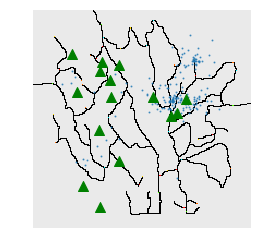

In [9]:
# Show the bitmap of the park mark
plt.imshow(img)

# Rather than iterating through the centoids, we can provide the plt.scatter method with the two vectors since opacity is fixed
plt.scatter(species_df["X"],200-species_df["Y"],s=1,alpha=0.7)
plt.scatter(testobservations["X"],200-testobservations["Y"],marker="^",c="green",s=100)

# Turn off the axis and display the visualisation
plt.axis('off')
plt.show()